In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.cluster import DBSCAN
from collections import defaultdict
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

In [ ]:
raw_path = "Datasets/Raw_Images/*.tiff"
image_paths = sorted(glob(raw_path))
raw_16bit = cv2.imread(image_paths[0], cv2.IMREAD_UNCHANGED)  # Load 16-bit grayscale
image = (raw_16bit / 256).astype(np.uint8)  # Scale to 8-bit for OpenCV


In [ ]:
# Import necessary libraries
import os  # For file and directory operations
import cv2  # OpenCV for image processing
import numpy as np  # Numerical operations
import pandas as pd  # Data handling with DataFrames
from skimage import io  # Image I/O operations
from skimage.measure import label, regionprops  # Image region analysis
from skimage.morphology import remove_small_objects  # Morphological operations

# Define input and output paths
input_folder= "Datasets\Raw_Images"
output_csv_folder= os.path.join(input_folder,"Centroid_CSVs")  # Folder for centroid CSVs
output_img_folder= os.path.join(input_folder,"Annotated_Images")  # Folder for annotated images

# Create output directories if they don't exist
os.makedirs(output_csv_folder, exist_ok=True)
os.makedirs(output_img_folder, exist_ok=True)

def pad_image(image, target_height=4600, target_width=4600):
    # Get current dimensions
    h, w = image.shape[:2]
    
    # Calculate padding amounts
    pad_top = (target_height - h) // 2
    pad_bottom = target_height - h - pad_top
    pad_left = (target_width - w) // 2
    pad_right = target_width - w - pad_left
    
    # Pad the image
    padded_image = cv2.copyMakeBorder(
        image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=(0, 0, 0)
    )
    
    return padded_image

# === PROCESS EACH IMAGE ===
# Loop through all files in the input folder


# Example usage in the processing loop
for filename in os.listdir(input_folder):
    if filename.lower().endswith((".tif", ".tiff")):
        file_path = os.path.join(input_folder, filename)
        print(f"🔍 Processing: {filename}")

        # Load image
        image = io.imread(file_path).astype(np.uint16)
        if image.ndim == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Normalize the image
        image_norm = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Apply padding to the image
        padded_image = pad_image(image_norm, 4600, 4600)

        # Continue with the rest of the processing (blurring, thresholding, etc.)
        blurred = cv2.GaussianBlur(padded_image, (3, 3), 0)
        _, binary = cv2.threshold(blurred, 20, 255, cv2.THRESH_BINARY)
        cleaned = remove_small_objects(binary.astype(bool), min_size=5)
        labels = label(cleaned)

        # Continue with the region analysis, centroid extraction, etc.
        output_img = np.zeros_like(cv2.cvtColor(padded_image, cv2.COLOR_GRAY2BGR))

    # Analyze each region in the labeled image
    for region in regionprops(labels):
        # Skip regions that are too small or too large
        if region.area< 5 or region.area >10000:
            continue

        # Get centroid coordinates and eccentricity
        y,x= region.centroid
        ecc= region.eccentricity

        # Classify as star (round) or streak (elongated)
        if ecc <0.85:  # Stars have lower eccentricity
            stars.append((x,y))
            # Draw white dot for stars
            cv2.circle(output_img,(int(x), int(y)),2,(255,255,255),-1)
        else:  # Streaks have higher eccentricity
            streaks.append((x,y))
            # Draw line showing streak orientation
            orientation = region.orientation
            length = region.major_axis_length * 2
            x0,y0 = x,y
            x1= x0 + np.cos(orientation) * length / 2
            y1= y0 - np.sin(orientation) * length / 2
            x2= x0 - np.cos(orientation) * length / 2
            y2= y0 + np.sin(orientation) * length / 2
            h,w= output_img.shape[:2]
            pt1= (int(np.clip(x1, 0, w - 1)), int(np.clip(y1, 0, h - 1)))
            pt2= (int(np.clip(x2, 0, w - 1)), int(np.clip(y2, 0, h - 1)))
            cv2.line(output_img, pt1, pt2, (255, 255, 255), 1)

    print(f"✅ Stars: {len(stars)} | Streaks: {len(streaks)}")

    # Save centroid data to CSV
    df = pd.DataFrame(stars + streaks, columns=["x", "y"])
    df["type"]= ["star"] * len(stars) + ["streak"] * len(streaks)
    csv_path= os.path.join(output_csv_folder,filename.replace(".tiff","_centroids.csv").replace(".tif","_centroids.csv"))
    df.to_csv(csv_path, index=False)

    # Save annotated image
    image_name= os.path.splitext(filename)[0] + "_annotated.png"
    img_path= os.path.join(output_img_folder,image_name)
    cv2.imwrite(img_path,output_img)

print("\n✅ Done. All images processed with CSV and visual outputs.")

# Import machine learning related libraries
from sklearn.model_selection import train_test_split  # For splitting dataset
from tensorflow.keras.models import Sequential  # Keras model class
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization  # NN layers
from tensorflow.keras.optimizers import Adam  # Optimizer
import time  # For timing operations

# Initialize lists to store image patches and their labels
patches,labels= [], []

# === Load patches from centroid CSVs ===
# Process each image file to extract patches around detected objects
for file in os.listdir(input_folder):
    if file.endswith(".tif") or file.endswith(".tiff"):
        img_path= os.path.join(input_folder, file)
        base_name= os.path.splitext(file)[0]
        csv_path= os.path.join(output_csv_folder, base_name + "_centroids.csv")
        if not os.path.exists(csv_path):
            continue

        # Load and preprocess image
        image= io.imread(img_path).astype(np.uint16)
        if image.ndim == 3:
            image= cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Read centroid data from CSV
        df= pd.read_csv(csv_path)
        for _, row in df.iterrows():
            x, y= int(row['x']), int(row['y'])
            label= 0 if row['type'] == 'star' else 1  # 0 for stars, 1 for streaks

            # Extract 32x32 patch around each centroid
            half= 16
            if y - half >= 0 and y + half < image.shape[0] and x - half >= 0 and x + half < image.shape[1]:
                patch = image[y - half:y + half, x - half:x + half]
                patches.append(patch)
                labels.append(label)

# === Prepare dataset ===
# Convert to numpy arrays and normalize pixel values
X= np.array(patches).reshape(-1, 32, 32, 1).astype("float32") / 255.0
y= np.array(labels)
# Split into training and testing sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

# Set up data augmentation to improve model generalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen= ImageDataGenerator(rotation_range=20, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

model= Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    BatchNormalization(),  # Normalize activations
    MaxPooling2D((2, 2)),  # Downsampling

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Classifier head
    Flatten(),  # Convert 3D features to 1D
    Dropout(0.4),  # Regularization
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Step 3: Train the model with augmented data
model.fit(datagen.flow(X_train, y_train, batch_size=32),validation_data=(X_test, y_test),epochs=15)

# Time the training process
start= time.time()
history= model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
train_time= time.time() - start

# Evaluate model performance
train_loss,train_acc= model.evaluate(X_train, y_train, verbose=0)
test_loss,test_acc= model.evaluate(X_test, y_test, verbose=0)

# Print results
print(f"\n✅ Training Accuracy: {train_acc:.4f}")
print(f"✅ Testing Accuracy: {test_acc:.4f}")
print(f"⏱️ Training Time: {train_time:.2f} seconds")

# Save the trained model
model.save("star_streak_classifier.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..5891].


Stars detected: 7
Streaks detected: 7
Unknown objects: 0

Dataset statistics:
Total objects: 14
Stars: 2
Streaks: 12
Unknown: 0


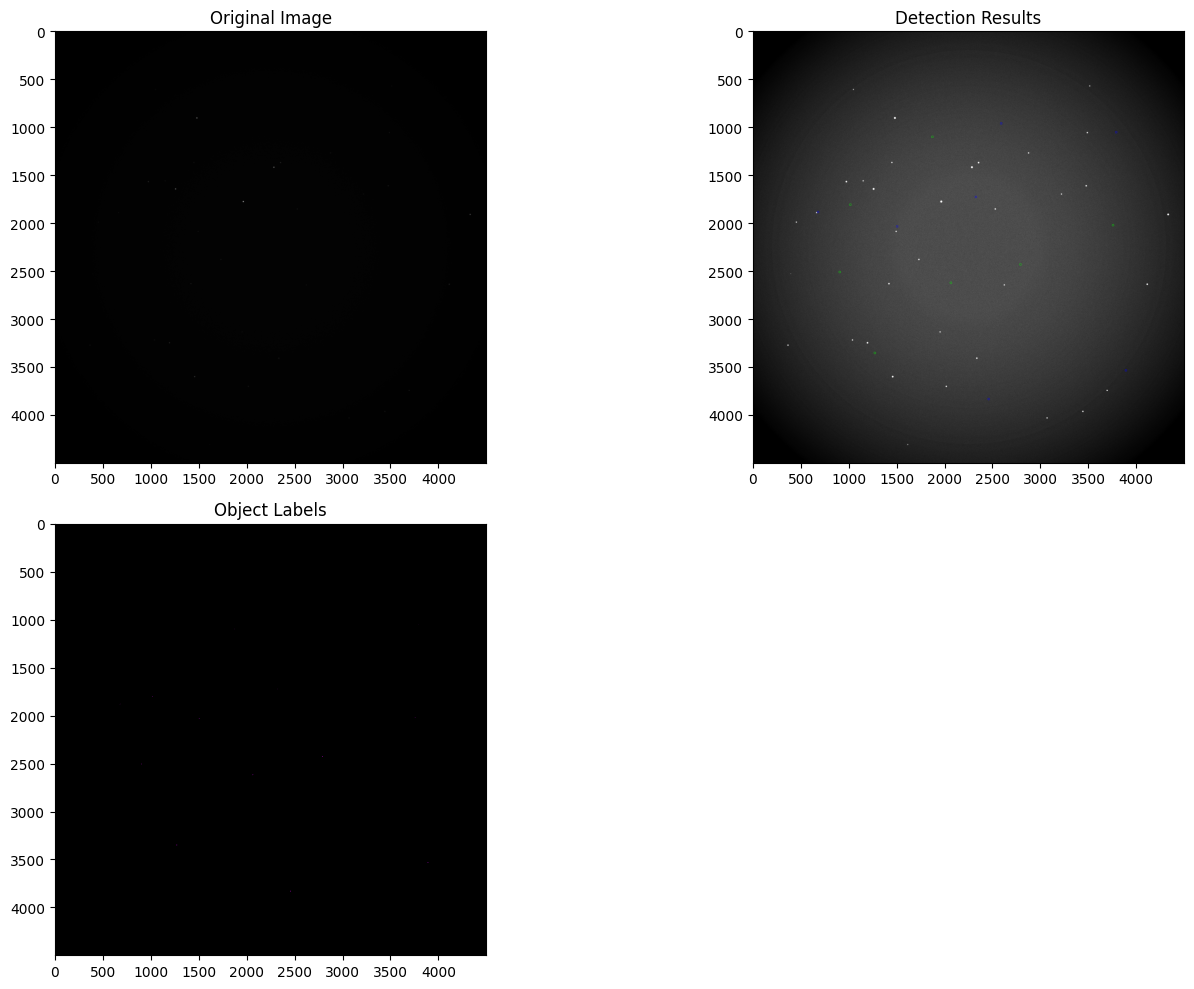

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from skimage import feature, morphology, measure, segmentation, filters
import cv2

class AstronomicalObjectDetector:
    """
    A class for detecting and classifying astronomical objects in images
    with emphasis on star and streak detection using limited unlabeled data.
    """
    
    def __init__(self):
        self.features = None
        self.labels = None
        self.object_types = ['star', 'streak', 'unknown']
        
    def preprocess_image(self, image, sigma=1.0):
        """
        Preprocess the astronomical image.
        
        Parameters:
        -----------
        image : numpy.ndarray
            Input astronomical image
        sigma : float
            Gaussian smoothing sigma
            
        Returns:
        --------
        numpy.ndarray
            Preprocessed image
        """
        # Convert to grayscale if needed
        if len(image.shape) > 2:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
            
        # Apply background subtraction (median filtering)
        bg = ndimage.median_filter(gray, size=25)
        diff = gray - bg
        
        # Apply Gaussian smoothing to reduce noise
        smoothed = filters.gaussian(diff, sigma=sigma)
        
        # Normalize to [0, 255] range
        normalized = ((smoothed - smoothed.min()) * 255 / 
                     (smoothed.max() - smoothed.min() + 1e-10)).astype(np.uint8)
        
        return normalized
    
    def detect_objects(self, image, min_area=5, threshold_factor=3.0):
        """
        Detect astronomical objects in the image.
        
        Parameters:
        -----------
        image : numpy.ndarray
            Input astronomical image
        min_area : int
            Minimum area (in pixels) for an object to be considered
        threshold_factor : float
            Factor multiplied by the standard deviation to compute threshold
            
        Returns:
        --------
        list
            List of detected object properties
        numpy.ndarray
            Labeled image
        """
        # Preprocess the image
        preprocessed = self.preprocess_image(image)
        
        # Adaptive thresholding based on image statistics
        threshold = np.mean(preprocessed) + threshold_factor * np.std(preprocessed)
        binary = preprocessed > threshold
        
        # Remove small objects
        cleaned = morphology.remove_small_objects(binary, min_size=min_area)
        
        # Label connected components
        labeled, num_objects = ndimage.label(cleaned)
        
        # Measure properties of labeled objects
        regions = measure.regionprops(labeled, intensity_image=preprocessed)
        
        objects = []
        for region in regions:
            # Extract basic properties
            obj = {
                'centroid': region.centroid,
                'area': region.area,
                'perimeter': region.perimeter,
                'eccentricity': region.eccentricity,
                'mean_intensity': region.mean_intensity,
                'max_intensity': region.max_intensity,
                'min_row': region.bbox[0],
                'min_col': region.bbox[1],
                'max_row': region.bbox[2],
                'max_col': region.bbox[3],
                'orientation': region.orientation,
                'major_axis_length': region.major_axis_length,
                'minor_axis_length': region.minor_axis_length,
                'bbox': region.bbox
            }
            
            # Calculate elongation (ratio of major to minor axis)
            if region.minor_axis_length > 0:
                obj['elongation'] = region.major_axis_length / region.minor_axis_length
            else:
                obj['elongation'] = 10.0  # Arbitrary high value for extreme elongation
                
            objects.append(obj)
            
        return objects, labeled
    
    def extract_features(self, objects):
        """
        Extract features from detected objects for classification.
        
        Parameters:
        -----------
        objects : list
            List of detected object properties
            
        Returns:
        --------
        numpy.ndarray
            Feature matrix for classification
        """
        if not objects:
            return np.array([])
            
        features = []
        for obj in objects:
            # Create feature vector for each object
            obj_features = [
                obj['area'],
                obj['eccentricity'],
                obj['mean_intensity'],
                obj['max_intensity'],
                obj['elongation'],
                obj['perimeter'] / (2 * np.sqrt(np.pi * obj['area'])),  # Circularity
                obj['major_axis_length'],
                obj['minor_axis_length'],
            ]
            features.append(obj_features)
            
        return np.array(features)
    
    def classify_objects(self, features, eps=0.5, min_samples=3, n_clusters=3):
        """
        Classify detected objects into stars, streaks, or unknown.
        
        Parameters:
        -----------
        features : numpy.ndarray
            Feature matrix of objects
        eps : float
            DBSCAN epsilon parameter
        min_samples : int
            DBSCAN min_samples parameter
        n_clusters : int
            Number of clusters for KMeans (fallback)
            
        Returns:
        --------
        numpy.ndarray
            Labels for each object (0: star, 1: streak, 2: unknown)
        """
        if features.shape[0] == 0:
            return np.array([])
            
        # Normalize features
        normalized_features = (features - np.mean(features, axis=0)) / (np.std(features, axis=0) + 1e-10)
        
        # Try PCA for dimensionality reduction if we have enough samples
        if features.shape[0] > 3:
            n_components = min(features.shape[0] - 1, features.shape[1], 3)
            pca = PCA(n_components=n_components)
            transformed_features = pca.fit_transform(normalized_features)
        else:
            transformed_features = normalized_features
            
        # Try clustering with DBSCAN
        try:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            db_labels = dbscan.fit_predict(transformed_features)
            
            # If DBSCAN found reasonable clusters, use them
            if len(np.unique(db_labels)) > 1 and np.count_nonzero(db_labels >= 0) > 0:
                labels = db_labels
                # -1 from DBSCAN means noise points, mark as unknown (2)
                labels[labels == -1] = 2
            else:
                # Fallback to KMeans
                kmeans = KMeans(n_clusters=min(n_clusters, features.shape[0]))
                labels = kmeans.fit_predict(transformed_features)
        except:
            # In case of any issues, use KMeans as fallback
            kmeans = KMeans(n_clusters=min(n_clusters, features.shape[0]))
            labels = kmeans.fit_predict(transformed_features)
            
        # Now we need to map cluster labels to astronomical object types
        # We'll use domain knowledge to assign labels:
        # - Stars typically have low elongation and high circularity
        # - Streaks have high elongation
        
        mean_elongation = []
        for label in np.unique(labels):
            if label == -1:  # DBSCAN noise points
                continue
            indices = np.where(labels == label)[0]
            mean_elong = np.mean([features[i][4] for i in indices])  # elongation is at index 4
            mean_elongation.append((label, mean_elong))
        
        # Sort clusters by mean elongation
        sorted_clusters = sorted(mean_elongation, key=lambda x: x[1])
        
        # Create mapping dictionary: lowest elongation → stars, highest → streaks
        label_map = {}
        for i, (label, _) in enumerate(sorted_clusters):
            if i == 0:
                label_map[label] = 0  # star
            elif i == len(sorted_clusters) - 1:
                label_map[label] = 1  # streak
            else:
                # Middle clusters depend on their elongation value
                if len(sorted_clusters) == 2:  # Only two clusters
                    label_map[label] = 1  # streak
                else:
                    label_map[label] = 0 if _ < 1.5 else 1  # Threshold for streak vs star
        
        # Map the labels
        final_labels = np.zeros_like(labels)
        for i, label in enumerate(labels):
            if label == -1:
                final_labels[i] = 2  # unknown
            else:
                final_labels[i] = label_map.get(label, 2)  # default to unknown
                
        return final_labels
    
    def process_image(self, image, min_area=5, threshold_factor=3.0):
        """
        Process an astronomical image to detect and classify objects.
        
        Parameters:
        -----------
        image : numpy.ndarray
            Input astronomical image
        min_area : int
            Minimum area for object detection
        threshold_factor : float
            Threshold factor for object detection
            
        Returns:
        --------
        dict
            Dictionary containing detected objects with classifications
        """
        # Detect objects
        objects, labeled_image = self.detect_objects(image, min_area, threshold_factor)
        
        if not objects:
            return {'stars': [], 'streaks': [], 'unknown': [], 'labeled_image': labeled_image}
            
        # Extract features
        self.features = self.extract_features(objects)
        
        # Classify objects
        self.labels = self.classify_objects(self.features)
        
        # Organize results by object type
        stars = []
        streaks = []
        unknown = []
        
        for i, obj in enumerate(objects):
            if i >= len(self.labels):
                unknown.append(obj)
                continue
                
            label = self.labels[i]
            obj['label'] = self.object_types[label]
            
            if label == 0:  # star
                stars.append(obj)
            elif label == 1:  # streak
                streaks.append(obj)
            else:  # unknown
                unknown.append(obj)
                
        return {
            'stars': stars,
            'streaks': streaks,
            'unknown': unknown,
            'labeled_image': labeled_image
        }
    
    def visualize_results(self, image, results):
        """
        Visualize the detection and classification results.
        
        Parameters:
        -----------
        image : numpy.ndarray
            Original input image
        results : dict
            Results from process_image
            
        Returns:
        --------
        numpy.ndarray
            Visualization image with annotated objects
        """
        # Create a color visualization image
        if len(image.shape) > 2:
            viz_img = image.copy()
        else:
            viz_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            
        # Draw stars in green
        for star in results['stars']:
            y, x = star['centroid']
            cv2.circle(viz_img, (int(x), int(y)), 10, (0, 255, 0), 2)
            
        # Draw streaks in red with orientation line
        for streak in results['streaks']:
            y, x = streak['centroid']
            cv2.circle(viz_img, (int(x), int(y)), 10, (0, 0, 255), 2)
            
            # Draw orientation line
            if streak['major_axis_length'] > 0:
                dx = streak['major_axis_length'] * 0.5 * np.cos(streak['orientation'] + np.pi/2)
                dy = streak['major_axis_length'] * 0.5 * np.sin(streak['orientation'] + np.pi/2)
                
                start_x = int(x - dx)
                start_y = int(y - dy)
                end_x = int(x + dx)
                end_y = int(y + dy)
                
                cv2.line(viz_img, (start_x, start_y), (end_x, end_y), (0, 0, 255), 2)
                
        # Draw unknowns in blue
        for obj in results['unknown']:
            y, x = obj['centroid']
            cv2.circle(viz_img, (int(x), int(y)), 10, (255, 0, 0), 2)
            
        return viz_img
    
    def analyze_dataset(self, images):
        """
        Analyze a dataset of astronomical images.
        
        Parameters:
        -----------
        images : list
            List of astronomical images
            
        Returns:
        --------
        dict
            Dictionary with analysis results
        """
        all_features = []
        all_objects = []
        
        for image in images:
            # Process each image
            results = self.process_image(image)
            
            # Collect features and objects
            if self.features is not None and len(self.features) > 0:
                all_features.append(self.features)
                all_objects.extend(results['stars'] + results['streaks'] + results['unknown'])
                
        # Combine features
        if all_features:
            combined_features = np.vstack(all_features)
            
            # Get insights from the combined dataset
            insights = {
                'total_objects': len(all_objects),
                'stars_count': len([obj for obj in all_objects if obj.get('label') == 'star']),
                'streaks_count': len([obj for obj in all_objects if obj.get('label') == 'streak']),
                'unknown_count': len([obj for obj in all_objects if obj.get('label') == 'unknown']),
                'feature_means': np.mean(combined_features, axis=0),
                'feature_stds': np.std(combined_features, axis=0)
            }
        else:
            insights = {
                'total_objects': 0,
                'stars_count': 0,
                'streaks_count': 0,
                'unknown_count': 0
            }
            
        return insights
import tifffile as tiff

# Example usage
def demo_with_synthetic_data():
    """
    Demonstrate the detector with synthetic data
    """
    # Create a synthetic astronomical image (stars and streaks)
    def create_synthetic_image(width=512, height=512, num_stars=50, num_streaks=10, noise_level=10):
        # Create empty image
        img = np.zeros((height, width), dtype=np.uint8)
        
        # Add stars (circular Gaussian blobs)
        for _ in range(num_stars):
            x = np.random.randint(20, width-20)
            y = np.random.randint(20, height-20)
            intensity = np.random.randint(100, 255)
            sigma = np.random.uniform(1.0, 3.0)
            
            y_idx, x_idx = np.mgrid[-10:11, -10:11]
            star = intensity * np.exp(-(x_idx**2 + y_idx**2) / (2 * sigma**2))
            
            # Add star to image with bounds checking
            y1, y2 = max(0, y-10), min(height, y+11)
            x1, x2 = max(0, x-10), min(width, x+11)
            star_y1, star_y2 = max(0, 10-y), min(21, height-y+10)
            star_x1, star_x2 = max(0, 10-x), min(21, width-x+10)
            
            img[y1:y2, x1:x2] = np.maximum(
                img[y1:y2, x1:x2], 
                star[star_y1:star_y2, star_x1:star_x2]
            )
        
        # Add streaks (elongated Gaussian blobs)
        for _ in range(num_streaks):
            x = np.random.randint(30, width-30)
            y = np.random.randint(30, height-30)
            intensity = np.random.randint(100, 255)
            length = np.random.randint(10, 30)
            width_factor = np.random.uniform(0.2, 0.5)
            angle = np.random.uniform(0, np.pi)
            
            y_idx, x_idx = np.mgrid[-20:21, -20:21]
            # Rotate coordinates
            x_rot = x_idx * np.cos(angle) + y_idx * np.sin(angle)
            y_rot = -x_idx * np.sin(angle) + y_idx * np.cos(angle)
            # Create elongated Gaussian
            streak = intensity * np.exp(-(x_rot**2 / (2 * (length * 0.5)**2) + 
                                          y_rot**2 / (2 * (length * width_factor)**2)))
            
            # Add streak to image with bounds checking
            y1, y2 = max(0, y-20), min(height, y+21)
            x1, x2 = max(0, x-20), min(width, x+21)
            streak_y1, streak_y2 = max(0, 20-y), min(41, height-y+20)
            streak_x1, streak_x2 = max(0, 20-x), min(41, width-x+20)
            
            img[y1:y2, x1:x2] = np.maximum(
                img[y1:y2, x1:x2], 
                streak[streak_y1:streak_y2, streak_x1:streak_x2]
            )
        
        # Add noise
        noise = np.random.normal(0, noise_level, (height, width))
        img = np.clip(img + noise, 0, 255).astype(np.uint8)
        
        return img
    
    # Create synthetic dataset
    dataset = [cv2.imread('Datasets\Raw_Images\Raw_Observation_016_Set2.tiff',cv2.IMREAD_UNCHANGED)]
    
    # Initialize detector
    detector = AstronomicalObjectDetector()
    
    # Process a single image
    results = detector.process_image(dataset[0])
    
    # Visualize results
    viz_img = detector.visualize_results(dataset[0], results)
    
    # Display results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(221)
    plt.imshow(dataset[0], cmap='gray')
    plt.title('Original Image')
    
    plt.subplot(222)
    plt.imshow(viz_img)
    plt.title('Detection Results')
    
    # Show labeled image
    plt.subplot(223)
    plt.imshow(results['labeled_image'], cmap='nipy_spectral')
    plt.title('Object Labels')
    
    # Print statistics
    print(f"Stars detected: {len(results['stars'])}")
    print(f"Streaks detected: {len(results['streaks'])}")
    print(f"Unknown objects: {len(results['unknown'])}")
    
    # Analyze dataset
    insights = detector.analyze_dataset(dataset)
    print(f"\nDataset statistics:")
    print(f"Total objects: {insights['total_objects']}")
    print(f"Stars: {insights['stars_count']}")
    print(f"Streaks: {insights['streaks_count']}")
    print(f"Unknown: {insights['unknown_count']}")
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    demo_with_synthetic_data()

(4500, 4500)


In [18]:
!pip install tqdm


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


Loading TIFF images: 100%|██████████| 35/35 [00:12<00:00,  2.70it/s]


Loaded 35 TIFF images from Datasets\Raw_Images
Training on 28 images, testing on 7 images


Extracting patches:   0%|          | 0/28 [02:03<?, ?it/s]


KeyboardInterrupt: 